In [2]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from mingpt.model import GPT
from mingpt.utils import set_seed
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import numpy as np
from scipy.stats import norm
set_seed(3407)

In [3]:
# Load in UL2 tokenizer to see what's going on
from transformers import AutoTokenizer, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

new_tokens = [f'<new_id_{i}>' for i in range(200)]
tokenizer.add_tokens(new_tokens)
tokenizer.add_tokens(['[S2S]', '[NLU]', '[NLG]'])

tokenizer

PreTrainedTokenizer(name_or_path='gpt2', vocab_size=50257, model_max_len=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True)})

In [4]:
dataset = load_dataset("togethercomputer/RedPajama-Data-1T-Sample", 'plain_text', cache_dir='datasets')
dataset = dataset['train']

# Custom dataset class for the Red Pajama dataset
class RedPajamaDataset(Dataset):
    def __init__(self, data, max_length=1024, ul2_switch=False):
        self.data = data
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.tokenizer.add_tokens([f'new_id_{i}' for i in range(200)])
        self.tokenizer.add_tokens(['[S2S]', '[NLU]', '[NLG]'])
        self.tokenizer.pad_token_id = 50256
        self.max_length = max_length - 1
        self.vocab_size = len(self.tokenizer)
        self.token_dict = {'s': ['[S2S]', self._s_denoising], 'r': ['[NLU]', self._r_denoising], 'x': ['[NLG]', self._x_denoising]}
        self.ul2_switch = ul2_switch

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]['text']

        if self.ul2_switch:
            # Get the token to prepend and function to use.
            begin_id, func = self.token_dict[np.random.choice(['s', 'r', 'x'], size=1, p=[0.5, 0.25, 0.25])[0]]

            # Prepend token to string and tokenize
            text = begin_id + ' ' + text
            ids = self.tokenizer.encode(text, truncation=True, max_length=self.max_length, return_tensors='pt', add_special_tokens=True, padding=True)

            # Return the tokens
            return func(ids, self.tokenizer)
        
        elif not self.ul2_switch:
            # Tokenize the text
            tokens = self.tokenizer.encode(text, add_special_tokens=True, max_length=self.max_length, truncation=True, return_tensors='pt', padding=True)
            
            # Split the tokens into chunks of max_length
            # Shift the tokens to get targets (excluding the [CLS] token)
            target_tokens = tokens[:, 1:].clone()  # Exclude the [CLS] token
            tokens = tokens[:, :-1]  # Exclude the last token to match the shifted targets
            return tokens, target_tokens

    # Helper functions! These will implement the UL2 tokenization.
    def _r_denoising(self, ids, tokenizer, corruption_pct=0.15, span_length=np.arange(2, 6)):
        # Calculate the chance of corruption based on the corruption percentage,
        # mean span length, and the maximum span length
        chance = (corruption_pct / np.mean(span_length)) * (1 + np.max(span_length) / ids.shape[1])
        
        # Variable to store the old tokens (before corruption)
        old_toks = None

        # Variables for tracking the number of steps to skip and tokens used
        steps_to_skip = 0
        tokens_used = 0

        ids_shape = ids.shape[1]
        # Iterate through the tokens in the input sequence
        for i in range(1, ids_shape):
            # Skip steps if needed (due to recent corruption)
            if steps_to_skip > 0:
                steps_to_skip -= 1
                continue

            # Randomly decide whether to corrupt the current token
            rnd = np.random.random()
            if rnd < chance:
                # Get the token used for masking (corruption)
                mask_token = tokenizer.convert_tokens_to_ids(new_tokens[tokens_used])
                tokens_used += 1
                
                # Randomly choose a span length for corruption
                span = np.random.choice(span_length)

                # Update old_toks and ids with the corrupted span
                if old_toks is None:
                    old_toks = torch.tensor([[mask_token]])  # Initialize old_toks with the first mask_token
                    old_toks = torch.cat((old_toks, ids[:, i:i + span]), dim=1)  # Add the corrupted span to old_toks
                    ids = torch.cat((ids[:, :i], torch.tensor([[mask_token]]), ids[:, i + span:]), dim=1)  # Mask the corrupted span in ids

                    steps_to_skip = span
                else:
                    old_toks = torch.cat((old_toks, torch.tensor([[mask_token]]), ids[:, i:i + span]), dim=1)  # Add the corrupted span to old_toks
                    ids = torch.cat((ids[:, :i], torch.tensor([[mask_token]]), ids[:, i + span:]), dim=1)  # Mask the corrupted span in ids

                    # Update steps_to_skip to avoid overlapping corruption
                    steps_to_skip = span

        # Pad ids and old_toks to match the desired maximum length (R, X)
        ids = torch.cat((ids, torch.tensor([[tokenizer.eos_token_id] * (self.max_length - ids.shape[1])])), dim=1)
        old_toks = torch.cat((old_toks, torch.tensor([[tokenizer.eos_token_id] * (self.max_length - old_toks.shape[1])])), dim=1)

        return ids, old_toks



    def _s_denoising(self, ids, tokenizer):
        # Get the length of our input
        len_ids = ids.shape[1]

        # Build Gaussian distribution of probabilities for each token
        vals = np.linspace(-2, 2, len_ids)
        p = norm.pdf(vals, loc=0, scale=1)

        # Normalize the probabilities and get the index to remove
        remove_index = np.random.choice(np.arange(len_ids // 2 - 15, len_ids // 2 + 15))

        # Get the token we are using for this space
        mask_token = tokenizer.convert_tokens_to_ids(new_tokens[0])

        # Get the tokens we are removing
        old_toks = torch.cat((torch.tensor([[mask_token]]), ids[:, remove_index:].clone()), dim=1)

        # Mask the tokens
        ids = ids[:, :remove_index + 1].clone()
        ids[:, -1] = mask_token

        # Pad ids and old_toks to match the desired maximum length (S)
        ids = torch.cat((ids, torch.tensor([[tokenizer.eos_token_id] * (self.max_length - ids.shape[1])])), dim=1)
        old_toks = torch.cat((old_toks, torch.tensor([[tokenizer.eos_token_id] * (self.max_length - old_toks.shape[1])])), dim=1)

        return ids, old_toks



        
    def _x_denoising(self, ids, tokenizer, corruption_pct=0.50, span_length=np.arange(2,6)):
        return self._r_denoising(ids, tokenizer, corruption_pct, span_length)
    

# Create an instance of the custom dataset
red_pajama_dataset_F = RedPajamaDataset(dataset)
red_pajama_dataset_T = RedPajamaDataset(dataset, ul2_switch=True)

Found cached dataset red_pajama-data-1_t-sample (/Users/dylanskinner/Desktop/CS 674 Projects/MinGPT_UL2/datasets/togethercomputer___red_pajama-data-1_t-sample/plain_text/1.0.0/6ea3bc8ec2e84ec6d2df1930942e9028ace8c5b9d9143823cf911c50bbd92039)


  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# create a GPT instance
from mingpt.model import GPT
import os

checkpoint_dir = 'red_pajama'
dir_path = f'./checkpoints/{checkpoint_dir}'

if not os.path.exists(dir_path):
    # If the directory doesn't exist, create it
    os.makedirs(dir_path)
    checkpoints = os.listdir(dir_path)
else:
    checkpoints = os.listdir(dir_path)

checkpoints.sort()



model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = red_pajama_dataset_T.vocab_size
model_config.block_size = red_pajama_dataset_T.max_length
# model_config.checkpoint = f'checkpoints/{checkpoint_dir}/' + checkpoints[-1] if checkpoints else None
model_config.checkpoint = None
model_config.use_ul2 = True
model = GPT(model_config)

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = red_pajama_dataset_F.vocab_size
model_config.block_size = red_pajama_dataset_F.max_length
# model_config.checkpoint = f'checkpoints/{checkpoint_dir}/' + checkpoints[-1] if checkpoints else None
model_config.checkpoint = None
model_config.use_ul2 = False
model2 = GPT(model_config)

number of parameters: 2.56M
number of parameters: 2.56M


In [9]:
# create a Trainer object
from mingpt.trainer import Trainer
iters = 500

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = iters + model.iter_num if model_config.checkpoint else iters  # This is a change
train_config.num_workers = 0
train_config.checkpoint_iters = 100     # This is a change
train_config.batch_size = 1
train_config.checkpoint_name = f'{checkpoint_dir}/checkpoint_ul2'  # This is a change.
trainer = Trainer(train_config, model, red_pajama_dataset_T)

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = iters + model.iter_num if model_config.checkpoint else iters  # This is a change
train_config.num_workers = 0
train_config.checkpoint_iters = 100     # This is a change
train_config.batch_size = 1
train_config.checkpoint_name = f'{checkpoint_dir}/checkpoint_break'  # This is a change.
trainer2 = Trainer(train_config, model2, red_pajama_dataset_F)

running on device cpu
running on device cpu


iter_dt 0.00ms; iter 0: train loss 10.69954
iter_dt 971.65ms; iter 100: train loss 5.62758
iter_dt 501.43ms; iter 200: train loss 1.12558
iter_dt 481.43ms; iter 300: train loss 3.26710
iter_dt 506.68ms; iter 400: train loss 1.15159
iter_dt 0.00ms; iter 0: train loss 10.83819
iter_dt 178.93ms; iter 100: train loss 9.08965
iter_dt 941.06ms; iter 200: train loss 8.23680
iter_dt 32.46ms; iter 300: train loss 9.81027
iter_dt 481.70ms; iter 400: train loss 7.58708


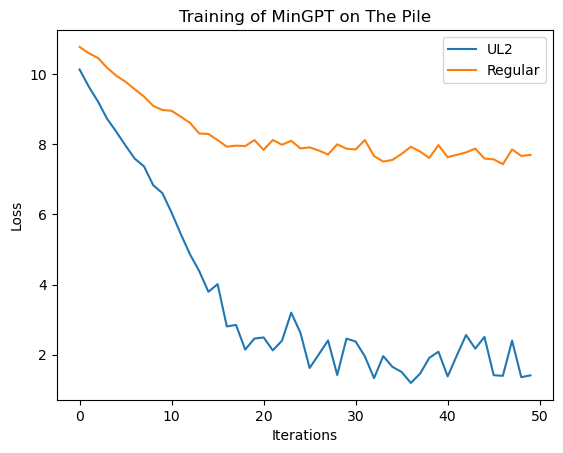

In [10]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

# Plot the loss
losses = trainer.curr_loss
x = 10
new_losses = np.mean(np.array(losses).reshape(-1, x), axis=1)

plt.plot(np.arange(len(new_losses)), new_losses, label='UL2')

def batch_end_callback(trainer):
    if trainer2.iter_num % 100 == 0:
        print(f"iter_dt {trainer2.iter_dt * 1000:.2f}ms; iter {trainer2.iter_num}: train loss {trainer2.loss.item():.5f}")
trainer2.set_callback('on_batch_end', batch_end_callback)

trainer2.run()

# Plot the loss
losses = trainer2.curr_loss
x = 10
new_losses = np.mean(np.array(losses).reshape(-1, x), axis=1)
plt.plot(np.arange(len(new_losses)), new_losses, label='Regular')
plt.title('Training of MinGPT on The Pile')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

number of parameters: 2.56M
number of parameters: 2.56M
running on device cpu
running on device cpu
iter_dt 517.40ms; iter 250: train loss 8.78332
iter_dt 483.15ms; iter 300: train loss 6.86103
iter_dt 500.55ms; iter 350: train loss 5.59939
iter_dt 477.28ms; iter 400: train loss 3.50742
iter_dt 125.39ms; iter 250: train loss 8.05119
iter_dt 416.90ms; iter 300: train loss 8.38999
iter_dt 80.89ms; iter 350: train loss 6.99281
iter_dt 369.91ms; iter 400: train loss 9.31628


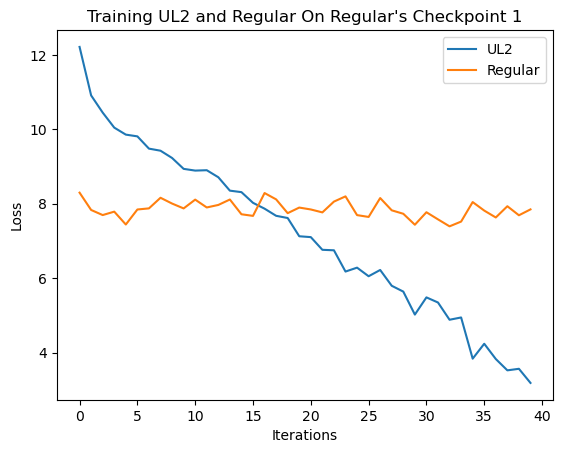

In [13]:
# Show that ul2 improves performance on checkpoint 1
# create a GPT instance
from mingpt.model import GPT
import os

checkpoint_dir = 'red_pajama'
dir_path = f'./checkpoints/{checkpoint_dir}'

if not os.path.exists(dir_path):
    # If the directory doesn't exist, create it
    os.makedirs(dir_path)
    checkpoints = os.listdir(dir_path)
else:
    checkpoints = os.listdir(dir_path)

checkpoints.sort()

# Lists for that good stuff.
check = torch.load(f'./checkpoints/{checkpoint_dir}/checkpoint_break_1.pth')
ul2_scores = [check['loss'].item()]
regular_scores = [check['loss'].item()]

# UL2
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = red_pajama_dataset_T.vocab_size
model_config.block_size = red_pajama_dataset_T.max_length
model_config.checkpoint = f'checkpoints/{checkpoint_dir}/checkpoint_break_1.pth'
model_config.use_ul2 = True
model = GPT(model_config)

# Regular
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = red_pajama_dataset_F.vocab_size
model_config.block_size = red_pajama_dataset_F.max_length
model_config.checkpoint = f'checkpoints/{checkpoint_dir}/checkpoint_break_1.pth'
model_config.use_ul2 = False
model2 = GPT(model_config)

# create a Trainer object
from mingpt.trainer import Trainer
iters = 200

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = iters + model.iter_num if model_config.checkpoint else iters  # This is a change
train_config.num_workers = 0
train_config.checkpoint_iters = 500     # This is a change
train_config.batch_size = 1
train_config.checkpoint_name = f'{checkpoint_dir}/checkpoint_ul2'  # This is a change.
trainer = Trainer(train_config, model, red_pajama_dataset_T)

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = iters + model.iter_num if model_config.checkpoint else iters  # This is a change
train_config.num_workers = 0
train_config.checkpoint_iters = 500     # This is a change
train_config.batch_size = 1
train_config.checkpoint_name = f'{checkpoint_dir}/checkpoint_break'  # This is a change.
trainer2 = Trainer(train_config, model2, red_pajama_dataset_F)

def batch_end_callback(trainer):
    if trainer.iter_num % 50 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

# Plot the loss
losses = trainer.curr_loss
ul2_scores.append(np.mean(losses))
x = 5
new_losses = np.mean(np.array(losses).reshape(-1, x), axis=1)
plt.plot(np.arange(len(new_losses)), new_losses, label='UL2')

def batch_end_callback(trainer):
    if trainer2.iter_num % 50 == 0:
        print(f"iter_dt {trainer2.iter_dt * 1000:.2f}ms; iter {trainer2.iter_num}: train loss {trainer2.loss.item():.5f}")
trainer2.set_callback('on_batch_end', batch_end_callback)

trainer2.run()

# Plot the loss
losses = trainer2.curr_loss
regular_scores.append(np.mean(losses))
x = 5
new_losses = np.mean(np.array(losses).reshape(-1, x), axis=1)
plt.plot(np.arange(len(new_losses)), new_losses, label='Regular')
plt.title('Training UL2 and Regular On Regular\'s Checkpoint 1')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

number of parameters: 2.56M
number of parameters: 2.56M
running on device cpu
running on device cpu
iter_dt 505.33ms; iter 350: train loss 8.83588
iter_dt 490.37ms; iter 400: train loss 7.58747
iter_dt 524.80ms; iter 450: train loss 4.69262
iter_dt 486.93ms; iter 500: train loss 2.42179
iter_dt 161.50ms; iter 350: train loss 7.74762
iter_dt 341.60ms; iter 400: train loss 8.24028
iter_dt 67.75ms; iter 450: train loss 7.95151
iter_dt 139.84ms; iter 500: train loss 7.50905


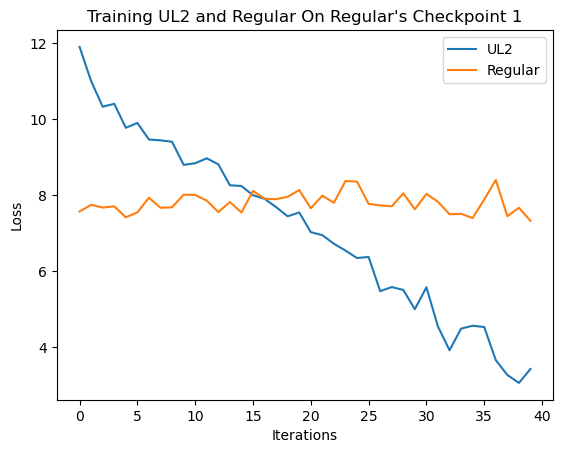

In [16]:
# Show that ul2 improves performance on checkpoint 1
# create a GPT instance
from mingpt.model import GPT
import os

checkpoint_dir = 'red_pajama'
dir_path = f'./checkpoints/{checkpoint_dir}'

if not os.path.exists(dir_path):
    # If the directory doesn't exist, create it
    os.makedirs(dir_path)
    checkpoints = os.listdir(dir_path)
else:
    checkpoints = os.listdir(dir_path)

checkpoints.sort()


# UL2
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = red_pajama_dataset_T.vocab_size
model_config.block_size = red_pajama_dataset_T.max_length
model_config.checkpoint = f'checkpoints/{checkpoint_dir}/checkpoint_break_2.pth'
model_config.use_ul2 = True
model = GPT(model_config)

# Regular
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = red_pajama_dataset_F.vocab_size
model_config.block_size = red_pajama_dataset_F.max_length
model_config.checkpoint = f'checkpoints/{checkpoint_dir}/checkpoint_break_2.pth'
model_config.use_ul2 = False
model2 = GPT(model_config)

# create a Trainer object
from mingpt.trainer import Trainer
iters = 200

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = iters + model.iter_num if model_config.checkpoint else iters  # This is a change
train_config.num_workers = 0
train_config.checkpoint_iters = 500     # This is a change
train_config.batch_size = 1
train_config.checkpoint_name = f'{checkpoint_dir}/checkpoint_ul2'  # This is a change.
trainer = Trainer(train_config, model, red_pajama_dataset_T)

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = iters + model.iter_num if model_config.checkpoint else iters  # This is a change
train_config.num_workers = 0
train_config.checkpoint_iters = 500     # This is a change
train_config.batch_size = 1
train_config.checkpoint_name = f'{checkpoint_dir}/checkpoint_break'  # This is a change.
trainer2 = Trainer(train_config, model2, red_pajama_dataset_F)

def batch_end_callback(trainer):
    if trainer.iter_num % 50 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

# Plot the loss
losses = trainer.curr_loss
ul2_scores.append(np.mean(losses))
x = 5
new_losses = np.mean(np.array(losses).reshape(-1, x), axis=1)
plt.plot(np.arange(len(new_losses)), new_losses, label='UL2')

def batch_end_callback(trainer):
    if trainer2.iter_num % 50 == 0:
        print(f"iter_dt {trainer2.iter_dt * 1000:.2f}ms; iter {trainer2.iter_num}: train loss {trainer2.loss.item():.5f}")
trainer2.set_callback('on_batch_end', batch_end_callback)

trainer2.run()

# Plot the loss
losses = trainer2.curr_loss
regular_scores.append(np.mean(losses))
x = 5
new_losses = np.mean(np.array(losses).reshape(-1, x), axis=1)
plt.plot(np.arange(len(new_losses)), new_losses, label='Regular')
plt.title('Training UL2 and Regular On Regular\'s Checkpoint 1')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

[8.23680305480957, 7.16313, 7.1179247]
[8.23680305480957, 7.8494177, 7.7943873]


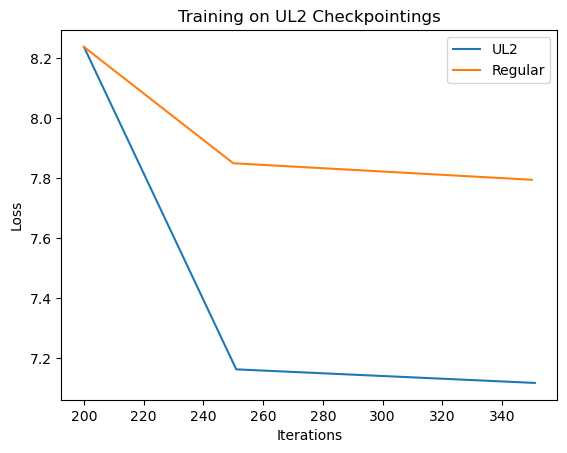

In [23]:
print(ul2_scores)
print(regular_scores)

plt.plot([200, 251, 351], ul2_scores, label='UL2')
plt.plot([200, 250, 350], regular_scores, label='Regular')
plt.title('Training on UL2 Checkpointings')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend()
plt.show()